In [1]:
from lanegcn import ActorNet, actor_gather
import os
import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number
import torch
from torch.utils.data import Sampler, DataLoader
from utils import Logger, load_pretrain
from lanegcn import get_model
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from skimage.transform import rotate

config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

In [2]:
avl = ArgoverseForecastingLoader('./dataset/train_mini/data')

In [3]:
print(avl)

Seq : /home/yan/GraghGAN/dataset/train_mini/data/64.csv
        ----------------------
        || City: MIA
        || # Tracks: 12
        ----------------------


In [4]:
avl.seq_list = sorted(avl.seq_list)
print(avl.seq_list)

[PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/1.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/10.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/101.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/103.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/104.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/105.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/106.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/107.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/108.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/109.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/110.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/111.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/112.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/113.csv'), PosixPath('/home/yan/GraghGAN/dataset/train_mini/data/115.csv'), PosixPath('/home/yan/GraghG

In [5]:
print(avl[0])
print(avl[1])

Seq : /home/yan/GraghGAN/dataset/train_mini/data/1.csv
        ----------------------
        || City: PIT
        || # Tracks: 12
        ----------------------
Seq : /home/yan/GraghGAN/dataset/train_mini/data/10.csv
        ----------------------
        || City: MIA
        || # Tracks: 101
        ----------------------


In [6]:
import os

import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number

import torch
from torch.utils.data import Sampler, DataLoader


from utils import Logger, load_pretrain
import matplotlib.pyplot as plt
from lanegcn import get_model

In [7]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

In [8]:
def worker_init_fn(pid):
    np_seed = int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)

dataset = Dataset('./dataset/preprocess/train_crs_dist6_angle90.p', config, train=True)
train_loader = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        shuffle=False,   # True: At each epoch, reorder the data
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,   # The next 36 were thrown away
        drop_last=True,
    )

In [9]:
data = {}
for i, data in enumerate(train_loader):
    data = dict(data)
    break


print(data.keys())

dict_keys(['city', 'orig', 'gt_preds', 'has_preds', 'theta', 'rot', 'feats', 'ctrs', 'graph', 'trajs2', 'traj1'])


LaneGCN

In [10]:
import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
from lanegcn import ActorNet, PredNet, MapNet, A2A, A2M, M2A, M2M, graph_gather, actor_gather
pred_net = PredNet(config)

actor_net = ActorNet(config)
map_net = MapNet(config)
a2m = A2M(config)
m2m = M2M(config)
m2a = M2A(config)
a2a = A2A(config)

# construct actor feature
actors, actor_idcs = actor_gather(data["feats"])
actor_ctrs = data["ctrs"]
actors = actor_net(actors)
# construct map features
graph = graph_gather(to_long(data["graph"]))
nodes, node_idcs, node_ctrs = map_net(graph)
nodes = a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
nodes = m2m(nodes, graph)
actors = m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
actors = a2a(actors, actor_idcs, actor_ctrs)

# prediction
out = pred_net(actors, actor_idcs, actor_ctrs)
rot, orig = data["rot"], data["orig"]

dict_keys(['cls', 'reg'])
32
torch.Size([6, 6, 30, 2])
torch.Size([30, 2])
tensor([[-1.0667, -1.7961],
        [ 0.4955,  1.1804],
        [-0.0115,  2.0610],
        [-2.4449, -0.2403],
        [ 0.1645, -0.4246],
        [-1.2254,  0.5454],
        [ 0.6068, -0.9615],
        [ 1.1911,  0.3064],
        [ 1.0456,  1.6346],
        [ 0.8621,  0.7337],
        [ 0.9300, -2.4808],
        [-0.8044,  0.7979],
        [-2.1744, -1.8781],
        [-2.7978,  0.2449],
        [ 0.7788,  0.4055],
        [ 0.7925, -0.2807],
        [-0.8717, -0.9385],
        [ 2.5240,  1.2371],
        [-0.2957,  0.6015],
        [-0.0301, -1.0615],
        [-1.1521, -2.2331],
        [ 0.7191,  0.1902],
        [-1.7164, -0.1202],
        [-0.4569,  1.4640],
        [-1.6377, -0.4001],
        [-2.8624, -0.4231],
        [ 0.2273,  0.7935],
        [ 0.6788, -0.0287],
        [ 2.8332, -0.3055],
        [ 1.5167, -0.4761]], grad_fn=<SelectBackward>)


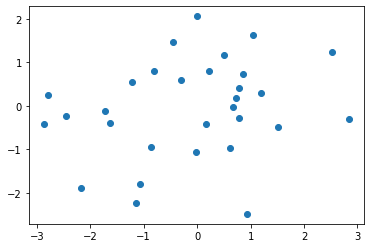

In [11]:
print(out.keys())
print(len(out['reg']))
print(out['reg'][0].size())   # reg_size = n_actors, 6, 30, 2

reg_a0_k0 = out['reg'][0][0][0]
print(reg_a0_k0.size())
print(reg_a0_k0)
plt.scatter(reg_a0_k0.detach().numpy()[:,0], reg_a0_k0.detach().numpy()[:,1])

In [12]:
traj1 = data['traj1'][0]
print(traj1.size())
traj_obs = traj1[0][:,:2]
print(reg_a0_k0.detach().numpy().shape)

torch.Size([6, 20, 3])
(30, 2)


tensor([[-2.9350e+01,  6.9829e-01],
        [-2.7669e+01,  6.1824e-01],
        [-2.5916e+01,  6.1834e-01],
        [-2.4357e+01,  5.5848e-01],
        [-2.2825e+01,  5.2700e-01],
        [-2.1702e+01,  4.6982e-01],
        [-1.9933e+01,  5.3166e-01],
        [-1.8591e+01,  4.0418e-01],
        [-1.6941e+01,  4.2177e-01],
        [-1.5494e+01,  3.2554e-01],
        [-1.3866e+01,  3.1888e-01],
        [-1.2298e+01,  3.3105e-01],
        [-1.0726e+01,  2.0914e-01],
        [-9.3659e+00,  2.3968e-01],
        [-7.7486e+00,  1.7806e-01],
        [-6.1332e+00,  1.8612e-01],
        [-4.6353e+00,  7.5501e-02],
        [-2.7170e+00,  6.0393e-02],
        [-1.5915e+00,  3.3193e-08],
        [ 1.0266e-05, -1.8155e-06]])
tensor([[-1.0667, -1.7961],
        [ 0.4955,  1.1804],
        [-0.0115,  2.0610],
        [-2.4449, -0.2403],
        [ 0.1645, -0.4246],
        [-1.2254,  0.5454],
        [ 0.6068, -0.9615],
        [ 1.1911,  0.3064],
        [ 1.0456,  1.6346],
        [ 0.8621,  0.7337],

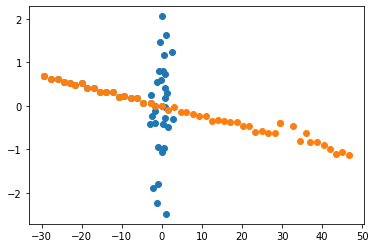

In [13]:
reg_a0_k0_all = torch.cat([traj_obs,reg_a0_k0])
print(traj_obs)
print(reg_a0_k0)
print(reg_a0_k0_all)
plt.scatter(reg_a0_k0_all.detach().numpy()[:,0],reg_a0_k0_all.detach().numpy()[:,1])

trajs2 = data['trajs2'][0]
plt.scatter(trajs2[0][:,0], trajs2[0][:,1])

In [19]:
trajs_allbs = torch.cat([data['traj1'][0][0],out['reg'][0][0][0]], dim=-2)

RuntimeError: Sizes of tensors must match except in dimension 0. Got 3 and 2 in dimension 1

In [14]:
# # transform prediction to world coordinates
# for i in range(len(out["reg"])):
#     out["reg"][i] = torch.matmul(out["reg"][i], rot[i]) + orig[i].view(1, 1, 1, -1)

In [15]:
# reg_a0_k0 = out['reg'][0][0][0]
# print(reg_a0_k0.size())
# print(reg_a0_k0)
# plt.scatter(reg_a0_k0.detach().numpy()[:,0], reg_a0_k0.detach().numpy()[:,1])